In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification, pipeline
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Define the maximum sequence length
MAX_SEQ_LENGTH = 128

# Load NER model for preprocessing
ner_tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
ner_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, device=device)

# NER preprocessing function
def extract_entities_and_anonymize(text):
    ner_results = ner_pipeline(text)
    extracted_entities = []

    # Replace entities with their labels
    for result in ner_results:
        start, end = result['start'], result['end']
        entity = result['word']
        label = result['entity']
        extracted_entities.append(entity)
        text = text[:start] + f"[{label}] " + text[end:]
    
    return text, extracted_entities

# Function to process a single text file and return sequences with labels for a specific tokenizer
def process_file(file_path, label, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Apply NER anonymization
    text, _ = extract_entities_and_anonymize(text)

    # Tokenize the entire text
    tokens = tokenizer(text, add_special_tokens=False)
    input_ids = tokens['input_ids']

    # Split the input IDs into chunks of MAX_SEQ_LENGTH
    chunks = [input_ids[i:i + MAX_SEQ_LENGTH] for i in range(0, len(input_ids), MAX_SEQ_LENGTH)]

    # Attach label and file name to each sequence
    labeled_sequences = [(chunk, label, file_path) for chunk in chunks]
    
    return labeled_sequences

# Function to process multiple files for a specific category
def process_category(file_paths, label, tokenizer):
    all_sequences = []
    file_sequence_counts = {}
    
    for file_path in file_paths:
        labeled_sequences = process_file(file_path, label, tokenizer)
        file_sequence_counts[file_path] = len(labeled_sequences)
        all_sequences.extend(labeled_sequences)
    
    return all_sequences, file_sequence_counts

# Function to convert sequences into a DataFrame
def sequences_to_dataframe(sequences, tokenizer):
    texts = [tokenizer.decode(seq[0]) for seq in sequences]
    labels = [seq[1] for seq in sequences]
    return pd.DataFrame({'content': texts, 'category': labels})

# Specify file paths for Train, Test, and Valid sets
test_files_0 = ["./data/train/0_The_Hound_of_the_Baskervilles_CD.txt"]
test_files_1 = ["./data/test/1_POIROT_INVESTIGATES.txt"]

valid_files_0 = ["./data/train/0_The_Man_Who_Was_Thursday_GKC.txt"]
valid_files_1 = ["./data/train/1_THE_BIG_FOUR.txt"]

train_files_0 = [
    "./data/train/0_The_Mystery_of_the_Yellow_Room_GL.txt",
    "./data/train/0_The_Middle_Temple_Murder_JF.txt",
    "./data/train/0_JOHN_THORNDYKE'S_CASES_RF.txt",
    "./data/train/0_A_Study_in_Scarlet_CD.txt",
    "./data/train/0_Tremendous_Trifles_GKC.txt",
    "./data/test/0_Caught_in_the_Net_EG.txt",
    "./data/valid/0_The_Red_House_Mystery_AM.txt"
]

train_files_1 = [
    "./data/train/1_The_Secret_of_Chimneys.txt",
    "./data/train/1_The_Mystery_of_the_Blue_Train.txt",
    "./data/train/1_The_Mysterious_Affair_at_Styles.txt",
    "./data/train/1_The_Murder_on_the_Links.txt",
    "./data/train/1_The_Murder_of_Roger_Ackroyd.txt",
    "./data/train/1_THE_MAN_IN_THE_BROWN_SUIT.txt",
    "./data/valid/1_THE_SECRET_ADVERSARY.txt"
]

# Tokenizers for each model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
xlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Prepare data for each model
def prepare_data(tokenizer):
    test_sequences = process_category(test_files_0, label=0, tokenizer=tokenizer)[0] + \
                     process_category(test_files_1, label=1, tokenizer=tokenizer)[0]
    valid_sequences = process_category(valid_files_0, label=0, tokenizer=tokenizer)[0] + \
                      process_category(valid_files_1, label=1, tokenizer=tokenizer)[0]
    train_sequences = process_category(train_files_0, label=0, tokenizer=tokenizer)[0] + \
                      process_category(train_files_1, label=1, tokenizer=tokenizer)[0]

    train_data = sequences_to_dataframe(train_sequences, tokenizer)
    valid_data = sequences_to_dataframe(valid_sequences, tokenizer)
    test_data = sequences_to_dataframe(test_sequences, tokenizer)

    return train_data, valid_data, test_data

# Generate datasets for each model
train_data_bert, valid_data_bert, test_data_bert = prepare_data(bert_tokenizer)
train_data_distilbert, valid_data_distilbert, test_data_distilbert = prepare_data(distilbert_tokenizer)
train_data_xlm, valid_data_xlm, test_data_xlm = prepare_data(xlm_tokenizer)

# Tokenization
def tokenize_texts(texts, tokenizer, max_length=MAX_SEQ_LENGTH):
    return tokenizer(
        list(texts),
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

# Tokenize for BERT
bert_train_encodings = tokenize_texts(train_data_bert['content'], bert_tokenizer)
bert_val_encodings = tokenize_texts(valid_data_bert['content'], bert_tokenizer)
bert_test_encodings = tokenize_texts(test_data_bert['content'], bert_tokenizer)

# Tokenize for DistilBERT
distilbert_train_encodings = tokenize_texts(train_data_distilbert['content'], distilbert_tokenizer)
distilbert_val_encodings = tokenize_texts(valid_data_distilbert['content'], distilbert_tokenizer)
distilbert_test_encodings = tokenize_texts(test_data_distilbert['content'], distilbert_tokenizer)

# Tokenize for XLM-RoBERTa
xlm_train_encodings = tokenize_texts(train_data_xlm['content'], xlm_tokenizer)
xlm_val_encodings = tokenize_texts(valid_data_xlm['content'], xlm_tokenizer)
xlm_test_encodings = tokenize_texts(test_data_xlm['content'], xlm_tokenizer)

# Prepare Dataset for PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

# Create PyTorch datasets for BERT
bert_train_dataset = CustomDataset(bert_train_encodings, train_data_bert['category'])
bert_val_dataset = CustomDataset(bert_val_encodings, valid_data_bert['category'])
bert_test_dataset = CustomDataset(bert_test_encodings, test_data_bert['category'])

# Create PyTorch datasets for DistilBERT
distilbert_train_dataset = CustomDataset(distilbert_train_encodings, train_data_distilbert['category'])
distilbert_val_dataset = CustomDataset(distilbert_val_encodings, valid_data_distilbert['category'])
distilbert_test_dataset = CustomDataset(distilbert_test_encodings, test_data_distilbert['category'])

# Create PyTorch datasets for XLM-RoBERTa
xlm_train_dataset = CustomDataset(xlm_train_encodings, train_data_xlm['category'])
xlm_val_dataset = CustomDataset(xlm_val_encodings, valid_data_xlm['category'])
xlm_test_dataset = CustomDataset(xlm_test_encodings, test_data_xlm['category'])

# Prepare Dataset for PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

# Create PyTorch datasets for BERT
bert_train_dataset = CustomDataset(bert_train_encodings, train_data_bert['category'])
bert_val_dataset = CustomDataset(bert_val_encodings, valid_data_bert['category'])
bert_test_dataset = CustomDataset(bert_test_encodings, test_data_bert['category'])

# Create PyTorch datasets for DistilBERT
distilbert_train_dataset = CustomDataset(distilbert_train_encodings, train_data_distilbert['category'])
distilbert_val_dataset = CustomDataset(distilbert_val_encodings, valid_data_distilbert['category'])
distilbert_test_dataset = CustomDataset(distilbert_test_encodings, test_data_distilbert['category'])

# Create PyTorch datasets for XLM-RoBERTa
xlm_train_dataset = CustomDataset(xlm_train_encodings, train_data_xlm['category'])
xlm_val_dataset = CustomDataset(xlm_val_encodings, valid_data_xlm['category'])
xlm_test_dataset = CustomDataset(xlm_test_encodings, test_data_xlm['category'])

# Plot metrics (loss and accuracy)
def plot_metrics(train_losses, eval_losses, eval_accuracies, model_name, fold):
    epochs = range(1, len(eval_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Per Epoch (Fold {fold + 1})')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Validation Accuracy Per Epoch (Fold {fold + 1})')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels, title):
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cross_validate_and_test(
    model_class, 
    model_name_or_path, 
    tokenizer, 
    train_data, 
    test_data, 
    num_folds=3, 
    model_name="Model"
):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    texts, labels = train_data['content'], train_data['category']  # Keep labels as a Pandas Series
    fold_metrics = []

    # Store predictions and labels across folds
    all_predictions = []
    all_labels = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\nFold {fold + 1}/{num_folds}")

        # Prepare fold datasets
        train_texts, val_texts = texts.iloc[train_idx], texts.iloc[val_idx]
        train_labels, val_labels = labels.iloc[train_idx], labels.iloc[val_idx]  # Use `.iloc` for alignment
        train_encodings = tokenize_texts(train_texts, tokenizer)
        val_encodings = tokenize_texts(val_texts, tokenizer)
        train_dataset = CustomDataset(train_encodings, train_labels)
        val_dataset = CustomDataset(val_encodings, val_labels)

        # Initialize model
        model = model_class.from_pretrained(model_name_or_path, num_labels=2)

        # TrainingArguments
        training_args = TrainingArguments(
            output_dir=f'./results_{model_name}_fold{fold}',
            evaluation_strategy='epoch',
            save_strategy='epoch',
            logging_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=4,
            weight_decay=0.01,
            logging_dir=f'./logs_{model_name}_fold{fold}',
            load_best_model_at_end=True,
            report_to="none"
        )

        # Metrics
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
            acc = accuracy_score(labels, predictions)
            return {'eval_accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        # Train the model
        trainer.train()

        # Extract metrics
        train_log = trainer.state.log_history
        epoch_logs = [log for log in train_log if 'epoch' in log.keys()]
        train_losses = [log['loss'] for log in epoch_logs if 'loss' in log]
        eval_losses = [log['eval_loss'] for log in epoch_logs if 'eval_loss' in log]
        eval_accuracies = [log['eval_accuracy'] for log in epoch_logs if 'eval_accuracy' in log]

        # Plot metrics for this fold
        plot_metrics(train_losses, eval_losses, eval_accuracies, model_name, fold)

        # Evaluate the model on validation set
        eval_results = trainer.evaluate(val_dataset)
        fold_metrics.append(eval_results)

        # Collect predictions and labels
        predictions, labels_actual, _ = trainer.predict(val_dataset)
        all_predictions.extend(np.argmax(predictions, axis=1))
        all_labels.extend(labels_actual)

        print(f"Metrics for Fold {fold + 1}: {eval_results}")

    # Confusion Matrix for Cross-Validation
    print("\nConfusion Matrix for Cross-Validation:")
    cv_cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cv_cm, display_labels=["Not Agatha 0", "Agatha 1"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name} (Cross-Validation)')
    plt.show()

    # Average metrics across folds
    avg_metrics = {key: np.mean([fold[key] for fold in fold_metrics]) for key in fold_metrics[0]}
    print(f"\nAverage Metrics Across {num_folds} Folds: {avg_metrics}")

    # Test Data Evaluation
    print("\nEvaluating on Test Data...")
    test_texts, test_labels = test_data['content'], test_data['category']
    test_encodings = tokenize_texts(test_texts, tokenizer)
    test_dataset = CustomDataset(test_encodings, test_labels)

    test_results = trainer.evaluate(test_dataset)
    print(f"\nTest Results for {model_name}: {test_results}")

    # Confusion Matrix for Test Data
    print("\nConfusion Matrix for Test Data:")
    test_predictions, test_labels_actual, _ = trainer.predict(test_dataset)
    test_pred_labels = np.argmax(test_predictions, axis=1)
    test_cm = confusion_matrix(test_labels_actual, test_pred_labels)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["Not Agatha 0", "Agatha 1"])
    disp_test.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name} (Test Data)')
    plt.show()

    return avg_metrics, test_results

C:\Users\kmusg\anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificat


Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kmusg\anaconda\Lib\site-packages\transformers\training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.179100,0.064604,0.980544,0.987528,0.974273,0.980856
2,0.037400,0.103337,0.977969,0.993653,0.963087,0.978131
3,0.007100,0.082964,0.984549,0.985987,0.983781,0.984882
4,0.001300,0.087146,0.985694,0.988751,0.983221,0.985979


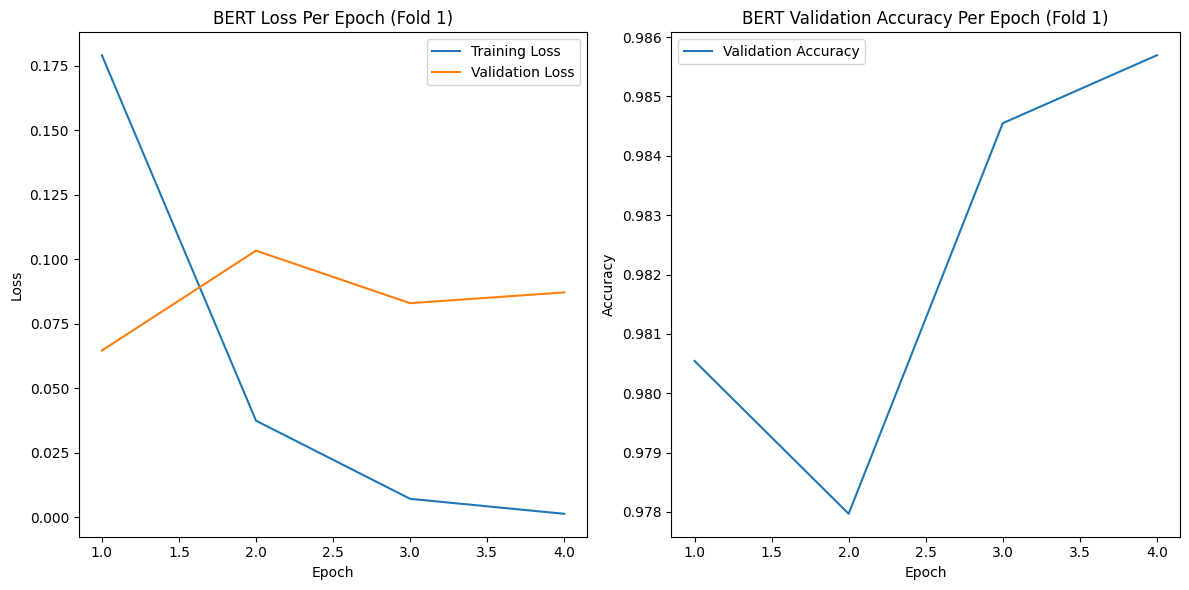

Metrics for Fold 1: {'eval_accuracy': 0.9805436337625179, 'eval_loss': 0.06460413336753845, 'eval_precision': 0.9875283446712018, 'eval_recall': 0.9742729306487695, 'eval_f1': 0.9808558558558559, 'eval_runtime': 2.4351, 'eval_samples_per_second': 1435.234, 'eval_steps_per_second': 45.172, 'epoch': 4.0}

Fold 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kmusg\anaconda\Lib\site-packages\transformers\training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.191600,0.069724,0.978255,0.967249,0.991051,0.979006
2,0.038100,0.087073,0.979113,0.966286,0.993848,0.979873
3,0.008500,0.066640,0.985694,0.984933,0.987136,0.986034
4,0.001300,0.069090,0.985694,0.982778,0.989374,0.986065


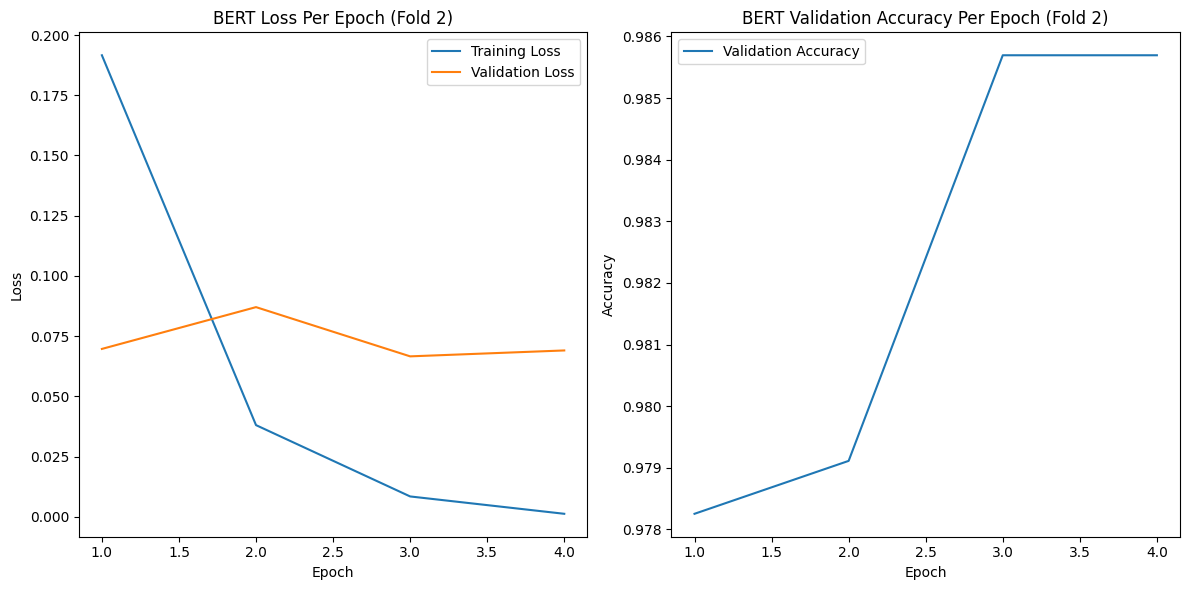

Metrics for Fold 2: {'eval_accuracy': 0.9856938483547926, 'eval_loss': 0.06663978844881058, 'eval_precision': 0.9849330357142857, 'eval_recall': 0.9871364653243848, 'eval_f1': 0.9860335195530726, 'eval_runtime': 2.4501, 'eval_samples_per_second': 1426.449, 'eval_steps_per_second': 44.895, 'epoch': 4.0}

Fold 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kmusg\anaconda\Lib\site-packages\transformers\training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.190700,0.092637,0.973955,0.995906,0.952994,0.973978
2,0.035600,0.055631,0.986835,0.992643,0.981533,0.987057
3,0.004900,0.059107,0.989410,0.990471,0.988808,0.989639
4,0.001700,0.064557,0.987693,0.985523,0.990487,0.987999


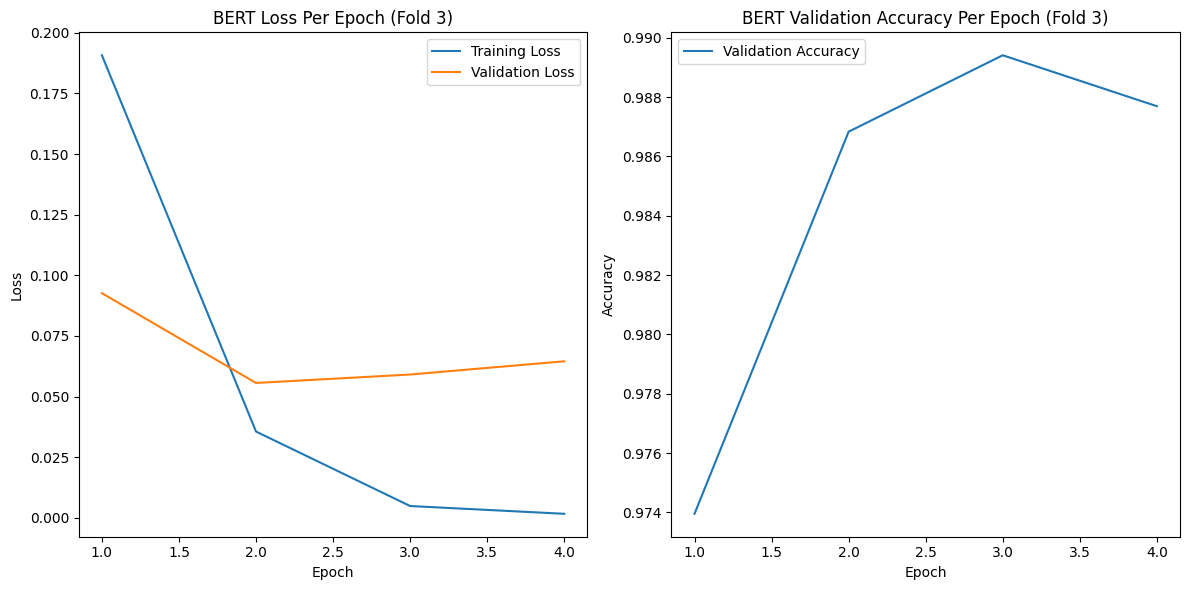

Metrics for Fold 3: {'eval_accuracy': 0.9868345735546652, 'eval_loss': 0.05563142150640488, 'eval_precision': 0.9926428975664969, 'eval_recall': 0.9815332960268607, 'eval_f1': 0.9870568373663478, 'eval_runtime': 2.4758, 'eval_samples_per_second': 1411.248, 'eval_steps_per_second': 44.43, 'epoch': 4.0}

Confusion Matrix for Cross-Validation:


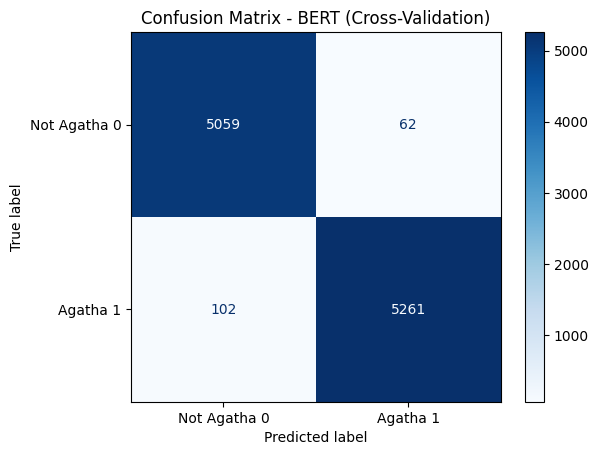


Average Metrics Across 3 Folds: {'eval_accuracy': 0.9843573518906585, 'eval_loss': 0.06229178110758463, 'eval_precision': 0.9883680926506614, 'eval_recall': 0.9809808973333384, 'eval_f1': 0.9846487375917587, 'eval_runtime': 2.4536666666666664, 'eval_samples_per_second': 1424.3103333333336, 'eval_steps_per_second': 44.83233333333334, 'epoch': 4.0}

Evaluating on Test Data...



Test Results for BERT: {'eval_accuracy': 0.8117953165654813, 'eval_loss': 0.9431427717208862, 'eval_precision': 0.7763975155279503, 'eval_recall': 0.8726003490401396, 'eval_f1': 0.8216926869350862, 'eval_runtime': 0.85, 'eval_samples_per_second': 1356.472, 'eval_steps_per_second': 43.529, 'epoch': 4.0}

Confusion Matrix for Test Data:


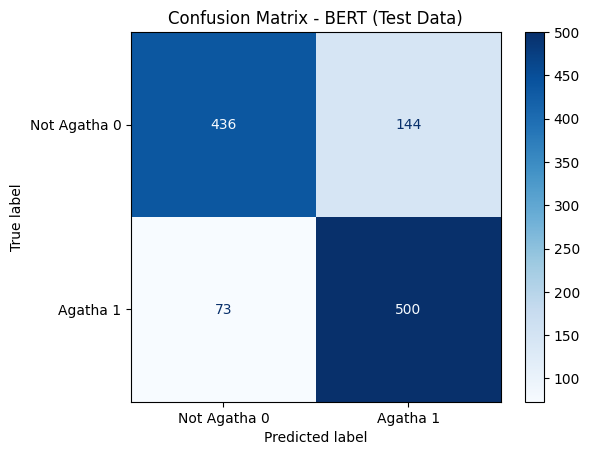

In [2]:
# # Cross-validate for BERT
# avg_metrics_bert = cross_validate_and_test(
#     model_class=BertForSequenceClassification,
#     model_name_or_path='bert-base-uncased',
#     tokenizer=bert_tokenizer,
#     train_data=train_data_bert,
#     test_data=test_data_bert,
#     num_folds=3,
#     model_name="BERT"
# )


avg_metrics_bert, test_results_bert = cross_validate_and_test(
    model_class=BertForSequenceClassification,
    model_name_or_path='bert-base-uncased',
    tokenizer=bert_tokenizer,
    train_data=train_data_bert,
    test_data=test_data_bert,
    num_folds=3,
    model_name="BERT"
)


Fold 1/3


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

C:\Users\kmusg\anaconda\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kmusg\.cache\huggingface\hub\models--distilbert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-ca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.215400,0.103839,0.967190,0.980304,0.955044,0.967509
2,0.057900,0.108126,0.977285,0.965296,0.991228,0.978090
3,0.018000,0.106623,0.979809,0.974026,0.986842,0.980392
4,0.005500,0.109272,0.980651,0.974581,0.987939,0.981214


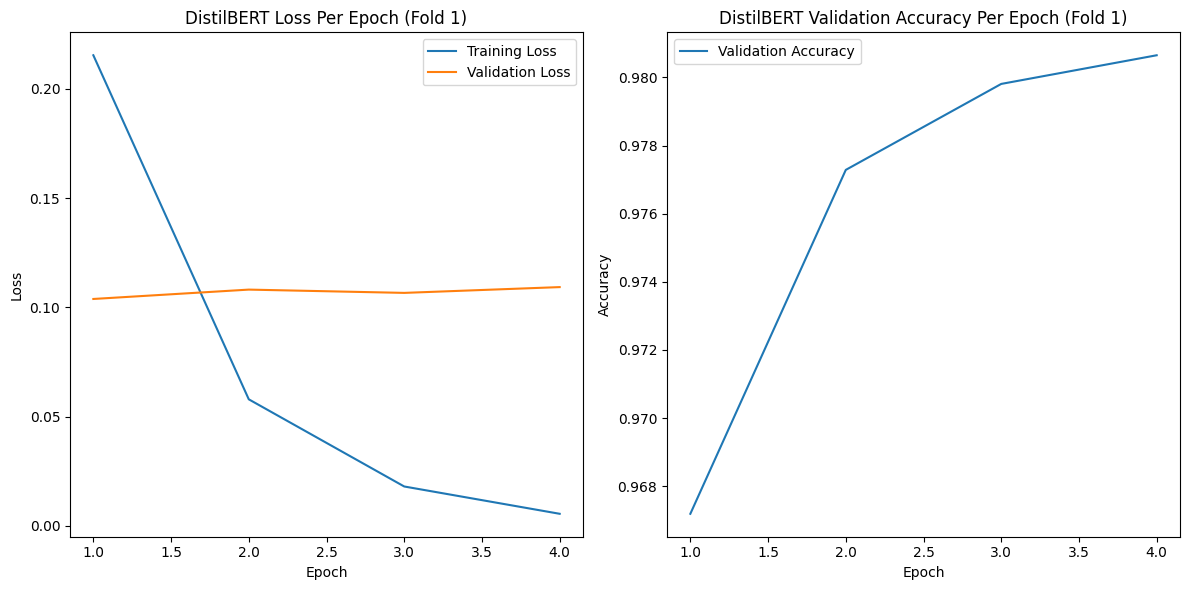

Metrics for Fold 1: {'eval_accuracy': 0.967190128996074, 'eval_loss': 0.10383940488100052, 'eval_precision': 0.9803038829487901, 'eval_recall': 0.9550438596491229, 'eval_f1': 0.9675090252707581, 'eval_runtime': 1.4418, 'eval_samples_per_second': 2473.354, 'eval_steps_per_second': 77.682, 'epoch': 4.0}

Fold 2/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kmusg\anaconda\Lib\site-packages\transformers\training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.214800,0.087534,0.971397,0.975704,0.968219,0.971947
2,0.065600,0.118733,0.972238,0.990341,0.955068,0.972385
3,0.019400,0.116330,0.977846,0.985000,0.971507,0.978207
4,0.005100,0.119822,0.978407,0.987723,0.969863,0.978712


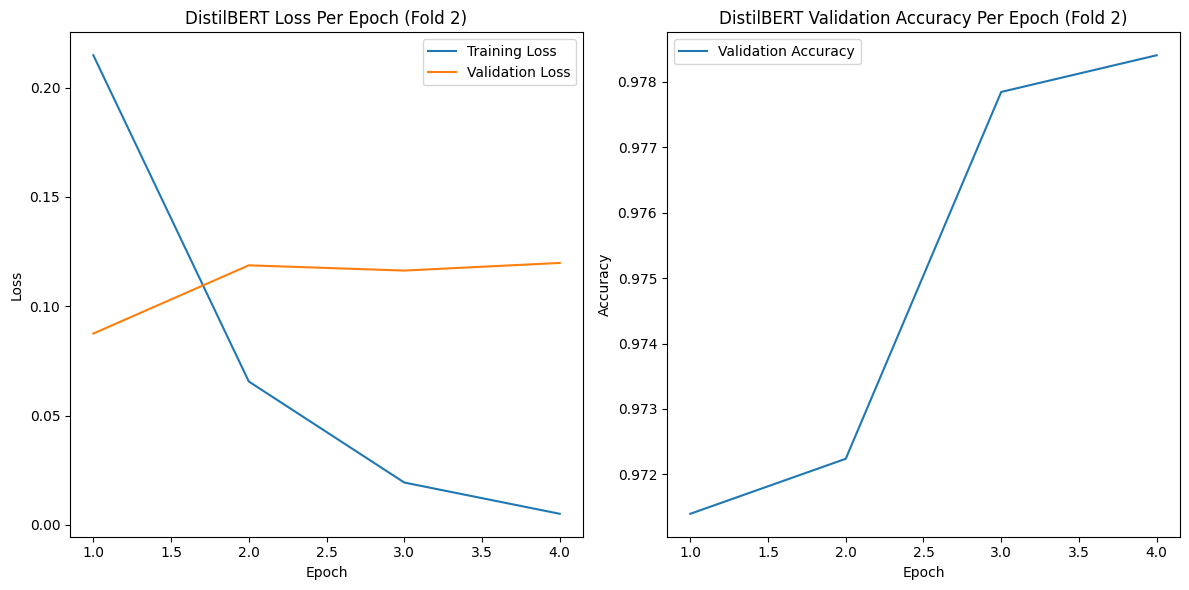

Metrics for Fold 2: {'eval_accuracy': 0.971396522714526, 'eval_loss': 0.08753427118062973, 'eval_precision': 0.9757040309221424, 'eval_recall': 0.9682191780821918, 'eval_f1': 0.971947194719472, 'eval_runtime': 1.4919, 'eval_samples_per_second': 2390.261, 'eval_steps_per_second': 75.073, 'epoch': 4.0}

Fold 3/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kmusg\anaconda\Lib\site-packages\transformers\training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.229600,0.108490,0.969986,0.981492,0.959430,0.970335
2,0.058300,0.119360,0.971950,0.955121,0.991776,0.973104
3,0.023100,0.092354,0.981206,0.980317,0.983004,0.981659
4,0.009300,0.097479,0.979523,0.977112,0.983004,0.980049


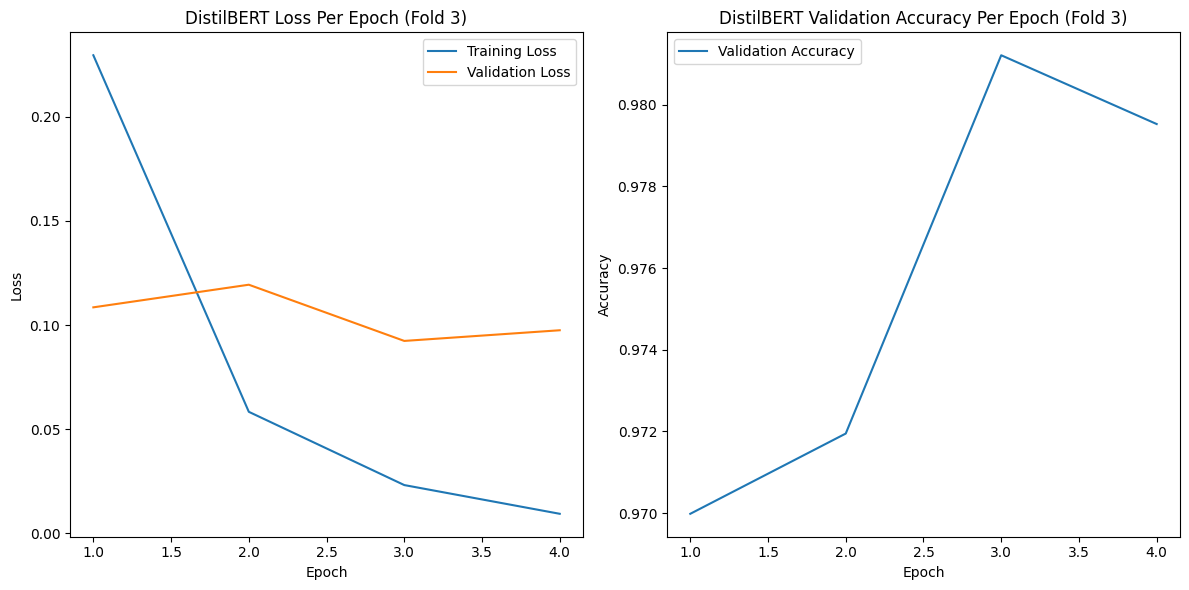

Metrics for Fold 3: {'eval_accuracy': 0.9812061711079944, 'eval_loss': 0.09235405921936035, 'eval_precision': 0.9803171131765992, 'eval_recall': 0.9830043859649122, 'eval_f1': 0.9816589104845332, 'eval_runtime': 1.3474, 'eval_samples_per_second': 2645.758, 'eval_steps_per_second': 83.121, 'epoch': 4.0}

Confusion Matrix for Cross-Validation:


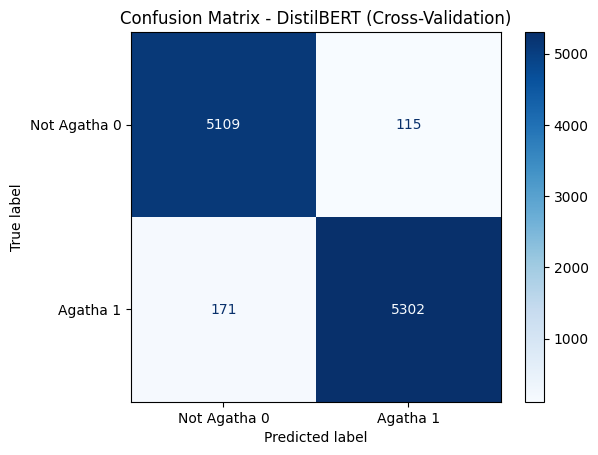


Average Metrics Across 3 Folds: {'eval_accuracy': 0.9732642742728648, 'eval_loss': 0.0945759117603302, 'eval_precision': 0.9787750090158439, 'eval_recall': 0.9687558078987424, 'eval_f1': 0.9737050434915878, 'eval_runtime': 1.4270333333333334, 'eval_samples_per_second': 2503.124333333333, 'eval_steps_per_second': 78.62533333333333, 'epoch': 4.0}

Evaluating on Test Data...



Test Results for DistilBERT: {'eval_accuracy': 0.8413910093299406, 'eval_loss': 0.8678907155990601, 'eval_precision': 0.794682422451994, 'eval_recall': 0.9180887372013652, 'eval_f1': 0.8519398258115598, 'eval_runtime': 0.4552, 'eval_samples_per_second': 2590.111, 'eval_steps_per_second': 81.284, 'epoch': 4.0}

Confusion Matrix for Test Data:


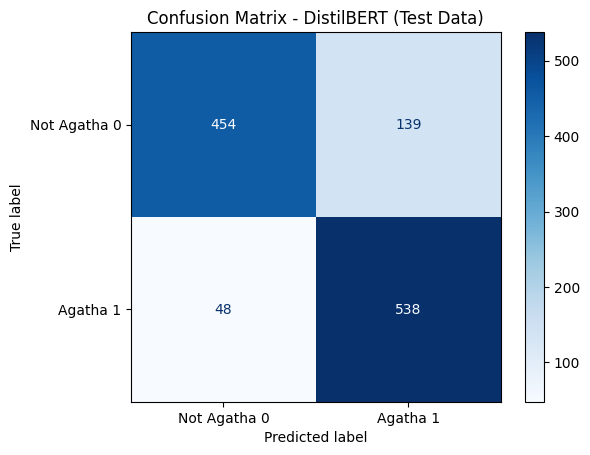

In [3]:
# Cross-validate for DistilBERT
avg_metrics_distilbert, test_results_distilbert = cross_validate_and_test(
    model_class=DistilBertForSequenceClassification,
    model_name_or_path='distilbert-base-cased',
    tokenizer=distilbert_tokenizer,
    train_data=train_data_distilbert,
    test_data=test_data_distilbert,
    num_folds=3,
    model_name="DistilBERT"
)


Fold 1/3


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

C:\Users\kmusg\anaconda\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kmusg\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and ar

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.311500,0.168169,0.963670,0.971353,0.956635,0.963938
2,0.121500,0.120729,0.970830,0.987568,0.954545,0.970776
3,0.053700,0.141095,0.977194,0.982577,0.972309,0.977416
4,0.023100,0.148856,0.976399,0.981023,0.972309,0.976647


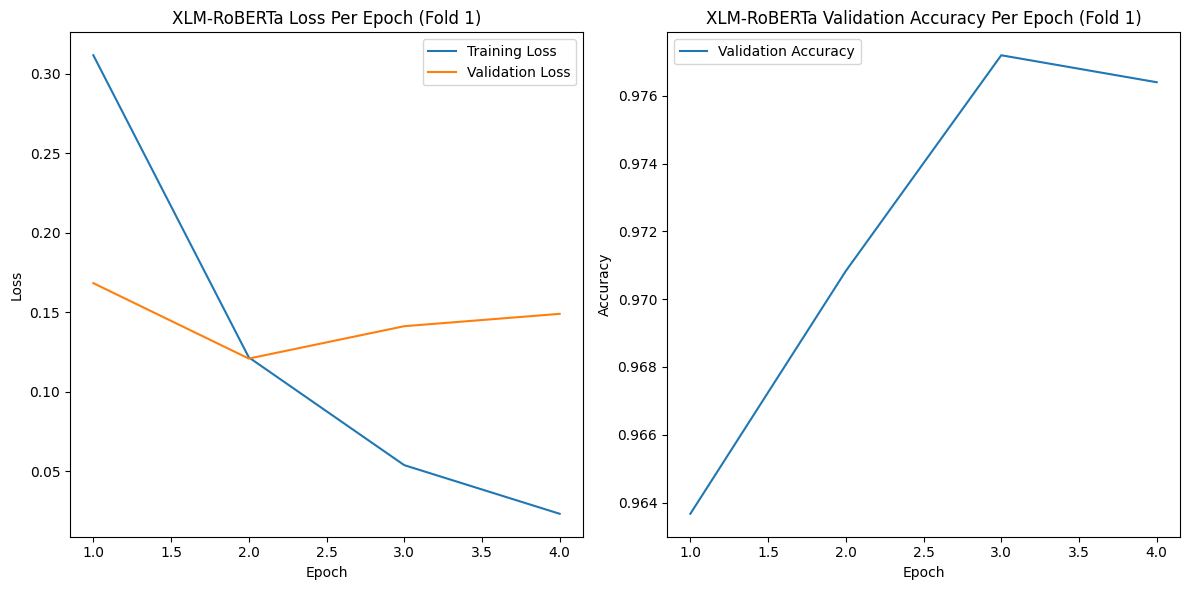

Metrics for Fold 1: {'eval_accuracy': 0.9708300185627154, 'eval_loss': 0.12072860449552536, 'eval_precision': 0.9875675675675676, 'eval_recall': 0.9545454545454546, 'eval_f1': 0.9707757704569607, 'eval_runtime': 2.6438, 'eval_samples_per_second': 1426.361, 'eval_steps_per_second': 44.633, 'epoch': 4.0}

Fold 2/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kmusg\anaconda\Lib\site-packages\transformers\training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.284300,0.136611,0.961018,0.944640,0.980669,0.962317
2,0.097500,0.136726,0.969504,0.950877,0.991118,0.970581
3,0.042500,0.140205,0.976134,0.989796,0.962905,0.976165
4,0.016400,0.137343,0.977990,0.976575,0.980146,0.978357


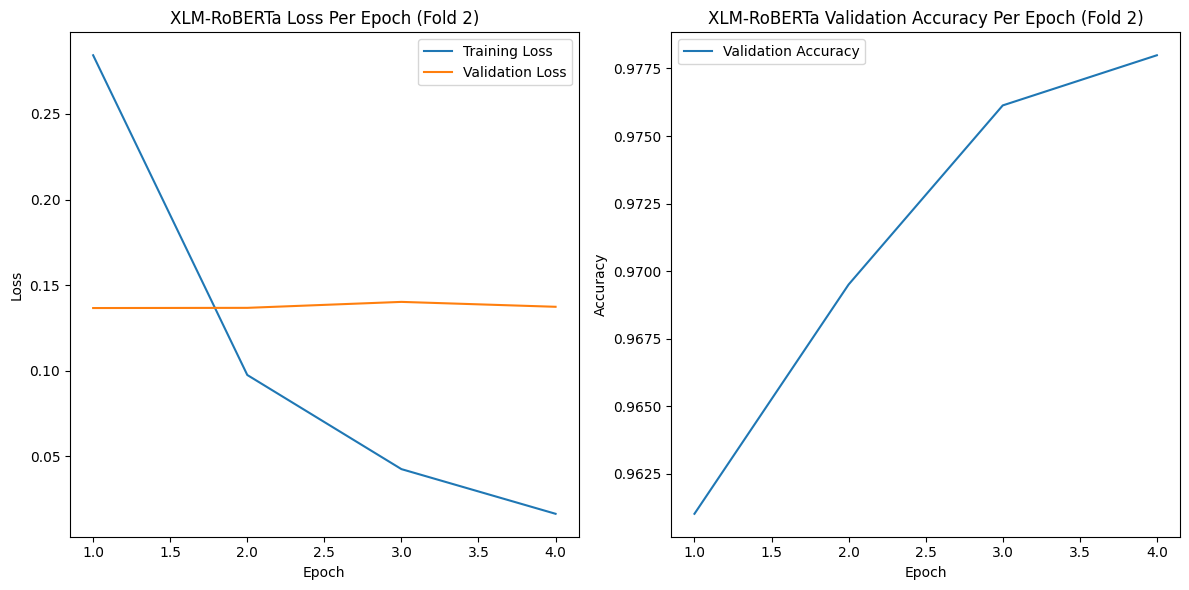

Metrics for Fold 2: {'eval_accuracy': 0.9610182975338106, 'eval_loss': 0.13661137223243713, 'eval_precision': 0.9446401610468043, 'eval_recall': 0.9806687565308255, 'eval_f1': 0.9623173545244809, 'eval_runtime': 2.7288, 'eval_samples_per_second': 1381.922, 'eval_steps_per_second': 43.242, 'epoch': 4.0}

Fold 3/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kmusg\anaconda\Lib\site-packages\transformers\training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.276100,0.196366,0.937152,0.893527,0.994778,0.941438
2,0.087700,0.137684,0.971360,0.964524,0.979634,0.972021
3,0.042100,0.111082,0.980111,0.973738,0.987467,0.980555
4,0.015800,0.116470,0.981968,0.976276,0.988512,0.982356


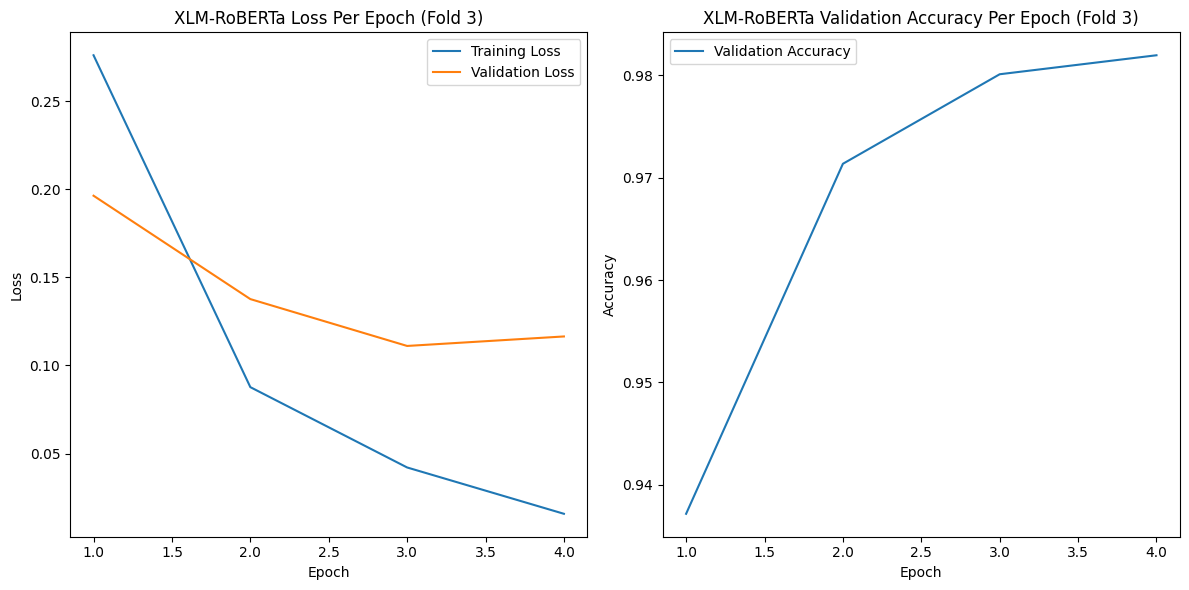

Metrics for Fold 3: {'eval_accuracy': 0.9801113762927606, 'eval_loss': 0.11108217388391495, 'eval_precision': 0.9737384140061792, 'eval_recall': 0.9874673629242819, 'eval_f1': 0.9805548353642728, 'eval_runtime': 2.6812, 'eval_samples_per_second': 1406.459, 'eval_steps_per_second': 44.01, 'epoch': 4.0}

Confusion Matrix for Cross-Validation:


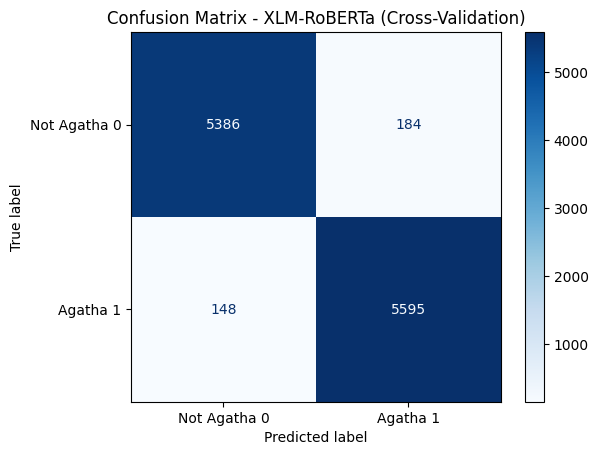


Average Metrics Across 3 Folds: {'eval_accuracy': 0.970653230796429, 'eval_loss': 0.12280738353729248, 'eval_precision': 0.9686487142068504, 'eval_recall': 0.9742271913335206, 'eval_f1': 0.9712159867819047, 'eval_runtime': 2.6846, 'eval_samples_per_second': 1404.914, 'eval_steps_per_second': 43.961666666666666, 'epoch': 4.0}

Evaluating on Test Data...



Test Results for XLM-RoBERTa: {'eval_accuracy': 0.8224, 'eval_loss': 1.2641242742538452, 'eval_precision': 0.768918918918919, 'eval_recall': 0.917741935483871, 'eval_f1': 0.836764705882353, 'eval_runtime': 0.8565, 'eval_samples_per_second': 1459.385, 'eval_steps_per_second': 46.7, 'epoch': 4.0}

Confusion Matrix for Test Data:


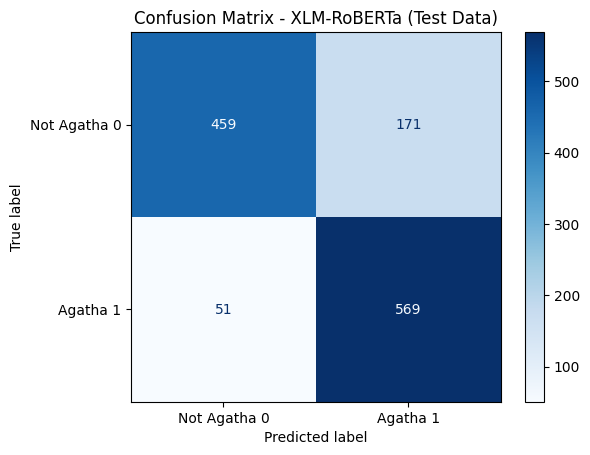

In [4]:
# Cross-validate for XLM-RoBERTa
avg_metrics_xlm, test_results_xlm = cross_validate_and_test(
    model_class=AutoModelForSequenceClassification,
    model_name_or_path='xlm-roberta-base',
    tokenizer=xlm_tokenizer,
    train_data=train_data_xlm,
    test_data=test_data_xlm,
    num_folds=3,
    model_name="XLM-RoBERTa"
)